In [78]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#SKLEARN?
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

Laden der Daten:

In [65]:
data = pd.read_csv("data_insurance.csv", sep = ";", names = ['age', 'sex', 'bmi', 'children', 'smoker', 'canton', "pbf", 'charges'])
data = data.iloc[1:]

data['charges'] = data['charges'].str.replace("’", "").apply(pd.to_numeric)
data['pbf'] = data['pbf'].apply(pd.to_numeric)
data['bmi'] = data['bmi'].apply(pd.to_numeric)
data['age'] = data['age'].apply(pd.to_numeric)
data['children'] = data['children'].apply(pd.to_numeric)

data = pd.read_csv("data_insurance.csv", sep = ";", names = ['age', 'sex', 'bmi', 'children', 'smoker', 'canton', "pbf", 'charges'])
data = data.iloc[1:]

data['charges'] = data['charges'].str.replace("’", "").apply(pd.to_numeric)
data['pbf'] = data['pbf'].apply(pd.to_numeric)
data['bmi'] = data['bmi'].apply(pd.to_numeric)
data['age'] = data['age'].apply(pd.to_numeric)
data['children'] = data['children'].apply(pd.to_numeric)

# 1 record with negative percentage of body fat.
data = data[data["pbf"]>0]
data = data.dropna()
print(data)

      age sex     bmi  children smoker canton    pbf  charges
1      19   w  24.720         0     ja     SO  35.94     4253
2      18   m  29.416         1   nein     AG  26.86     2494
3      28   m  28.800         3   nein     AG  26.92     3138
4      33   m  20.564         0   nein     BS   7.98     1553
5      32   m  25.504         0   nein     BS  21.84     2768
...   ...  ..     ...       ...    ...    ...    ...      ...
1334   50   m  27.176         3   nein     BS  23.02     5767
1335   18   w  27.936         0   nein     BL  42.18     2547
1336   18   w  31.880         0   nein     AG  49.59     3026
1337   21   w  23.040         0   nein     SO  31.18     2208
1338   61   w  25.656         0     ja     BS  38.63    19007

[1337 rows x 8 columns]


In [66]:
#index are not correct, don't know why, removed entries manually
children_outliers_to_del = data[(data['age'] <= 21) & (data['children'] == 5)].index.values - 1

for i in children_outliers_to_del:
    print(i)

#when these are removed, the score is worse by .10 for some reason but the mean absolute error drops by 60 points
data2 = data.drop(data.index[[32, 165, 983]])
data2[(data2['age'] <= 21) & (data2['children'] == 5)]

charges_outliers_to_del = data2[(data['charges'] >= 59000)].index.values - 1
for i in charges_outliers_to_del:
    print(i)

data_no_outliers = data2.drop(data.index[[542]])

data_no_outliers[(data['charges'] >= 59000)]

32
166
984
543


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,age,sex,bmi,children,smoker,canton,pbf,charges


In [67]:
data_trees_no_outliers = data_no_outliers.copy()

# Encode categorical variables.
data_no_outliers["sex"] = pd.factorize(data_no_outliers['sex'])[0]
data_no_outliers["smoker"] = pd.factorize(data_no_outliers['smoker'])[0]
data_no_outliers['canton'] = pd.factorize(data_no_outliers['canton'])[0]

# Encode categorical variables.
data_trees_no_outliers["female"] = data_trees_no_outliers["sex"] == "w"
data_trees_no_outliers["male"] = data_trees_no_outliers["sex"] == "m"
data_trees_no_outliers["smoker"] = data_trees_no_outliers["smoker"].apply(lambda x: x=="ja")
print(data_trees_no_outliers)
for canton_name in data_trees_no_outliers["canton"].unique():
    data_trees_no_outliers[canton_name.lower()] = data_trees_no_outliers["canton"] == canton_name

# Remove encoded categorical variables.
data_trees_no_outliers = data_trees_no_outliers.drop('sex', axis=1)
data_trees_no_outliers = data_trees_no_outliers.drop('canton', axis=1)


# Divide the charges into categories. Is there a more objective way to determine the categories? K-clustering?
bins = [1, 10000, 35000, 1000000]
bin_labels = [0, 1, 2]
data_trees_no_outliers["charges_level"] = pd.cut(data_trees_no_outliers["charges"], bins=bins, labels=bin_labels, include_lowest=True)
data_no_outliers["charges_level"] = pd.cut(data_no_outliers["charges"], bins=bins, labels=bin_labels, include_lowest=True)

print(data_no_outliers.head())

print(data_trees_no_outliers.head())

      age sex     bmi  children  smoker canton    pbf  charges  female   male
1      19   w  24.720         0    True     SO  35.94     4253    True  False
2      18   m  29.416         1   False     AG  26.86     2494   False   True
3      28   m  28.800         3   False     AG  26.92     3138   False   True
4      33   m  20.564         0   False     BS   7.98     1553   False   True
5      32   m  25.504         0   False     BS  21.84     2768   False   True
...   ...  ..     ...       ...     ...    ...    ...      ...     ...    ...
1334   50   m  27.176         3   False     BS  23.02     5767   False   True
1335   18   w  27.936         0   False     BL  42.18     2547    True  False
1336   18   w  31.880         0   False     AG  49.59     3026    True  False
1337   21   w  23.040         0   False     SO  31.18     2208    True  False
1338   61   w  25.656         0    True     BS  38.63    19007    True  False

[1333 rows x 10 columns]
   age  sex     bmi  children  smoker 

In [68]:
labels = np.array(data_no_outliers['charges'])
# The data we want to split = 'input'
input = data_no_outliers.drop('charges', axis=1).drop('charges_level', axis=1)

# The argument for the split function has to be an array
input = np.array(input)

# Split the data into training and test sets
train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.25, random_state = 42) 

labels_trees = np.array(data_trees_no_outliers['charges'])
# The data we want to split = 'input'
input_trees = data_trees_no_outliers.drop('charges', axis=1).drop('charges_level', axis=1)

# The argument for the split function has to be an array
input_trees = np.array(input_trees)

# Split the data into training and test sets
train_input_trees, test_input_trees, train_labels_trees, test_labels_trees = \
    train_test_split(input_trees, labels_trees, test_size = 0.25, random_state = 42) 

#### Linear Regression Confusion Matrix with a Base Model (Alpha = 0)

Its output was converted to match the categorical buckets.

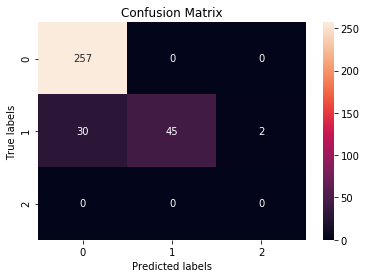

              precision    recall  f1-score   support

           0       1.00      0.90      0.94       287
           1       0.58      1.00      0.74        45
           2       0.00      0.00      0.00         2

    accuracy                           0.90       334
   macro avg       0.53      0.63      0.56       334
weighted avg       0.94      0.90      0.91       334



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
# define model
ridge_model = Ridge(alpha=0)
# fit model
ridge_model.fit(train_input, train_labels)

predics = ridge_model.predict(test_input)

bins = [1, 10000, 35000, 1000000]

predics_categorized = pd.cut(abs(predics), bins=bins, labels=bin_labels, include_lowest=True)
test_labels_categorized = pd.cut(abs(test_labels), bins=bins, labels=bin_labels, include_lowest=True)

cm = confusion_matrix(predics_categorized, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

#logistic_regression.score(X_test, y_test)
#plot_confusion_matrix(logistic_regression, X_test, y_test, display_labels = y_labels)
print(classification_report(test_labels_categorized, predics_categorized))

#### Logistic Regression using extended dataframe that's used for random forest as well

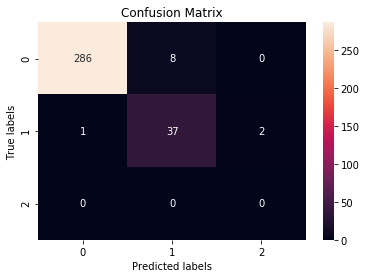

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       287
           1       0.93      0.82      0.87        45
           2       0.00      0.00      0.00         2

    accuracy                           0.97       334
   macro avg       0.63      0.61      0.62       334
weighted avg       0.96      0.97      0.96       334



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
logistic_regression = LogisticRegression(max_iter = 10000)
train_labels_categorized = pd.cut(abs(train_labels_trees), bins=bins, labels=bin_labels, include_lowest=True)
logistic_regression.fit(train_input_trees, train_labels_categorized)

label_prediction = logistic_regression.predict(test_input_trees)

cm = confusion_matrix(label_prediction, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

print(classification_report(test_labels_categorized, label_prediction))

#### Logistic Regression using same dataframe as in Ridge Regression

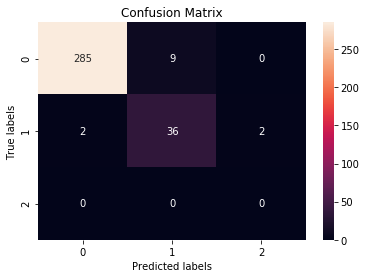

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       287
           1       0.90      0.80      0.85        45
           2       0.00      0.00      0.00         2

    accuracy                           0.96       334
   macro avg       0.62      0.60      0.61       334
weighted avg       0.95      0.96      0.96       334



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
logistic_regression = LogisticRegression(max_iter = 10000)
train_labels_categorized = pd.cut(abs(train_labels), bins=bins, labels=bin_labels, include_lowest=True)
logistic_regression.fit(train_input, train_labels_categorized)

label_prediction = logistic_regression.predict(test_input)

cm = confusion_matrix(label_prediction, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

print(classification_report(test_labels_categorized, label_prediction))

#### Random Forest

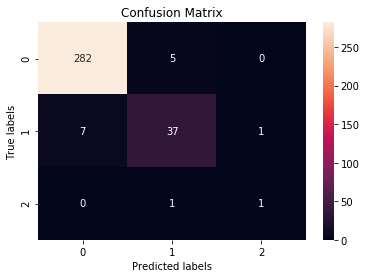

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       287
           1       0.86      0.82      0.84        45
           2       0.50      0.50      0.50         2

    accuracy                           0.96       334
   macro avg       0.78      0.77      0.77       334
weighted avg       0.96      0.96      0.96       334



In [74]:
model = RandomForestRegressor()
model.fit(train_input, train_labels)

# Round up prediction labels as integers
label_prediction = model.predict(test_input)

result = pd.DataFrame()
result['prediction'] = label_prediction
result['prediction_charges_level'] = pd.cut(result['prediction'],
                                            bins=bins, # use bins from before
                                            labels=bin_labels, 
                                            include_lowest=True)

result['actual'] = test_labels
result['actual_charges_level'] = pd.cut(result['actual'], 
                                        bins=bins, 
                                        labels=bin_labels, 
                                        include_lowest=True)


cm = confusion_matrix(result["actual_charges_level"], result["prediction_charges_level"])

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

print(classification_report(result["actual_charges_level"], result["prediction_charges_level"]))

#### Optimized Ridge Regression

[[-0.57735027 -0.57735027 -0.57735027]
 [-0.57533275  0.78940751 -0.21407476]
 [-0.57936076 -0.2085724   0.78793316]]


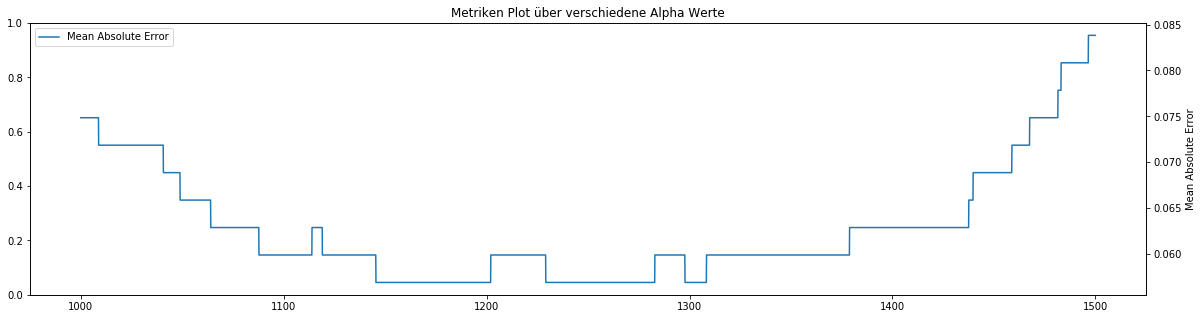

Mean Absolute Error min value: 0.05688622754491018
Alpha value for Mean Absolute Error min value: 1145.4145414541454


In [106]:
pca_data = data_no_outliers[['sex','bmi', 'pbf']]

X = pca_data.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print(components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

data4 = data_no_outliers.copy()
data4[['sex','bmi', 'pbf']] = np.dot(data4[['sex', 'bmi', 'pbf']].values, components_.T)

labels = np.array(data_no_outliers['charges'])

# The data we want to split = 'input'
input = data4.drop('sex', axis=1).drop('charges', axis = 1).drop('charges_level', axis = 1)

# The argument for the split function has to be an array
input = np.array(input)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.25, random_state = 42) 
train_input = np.array(train_input, dtype=np.float64)
test_input = np.array(test_input, dtype=np.float64)

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

maeArray = []

alphaRange = np.linspace(1000, 1500, 10000)
for i in alphaRange:  
    RidgeRegressor = Ridge(alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)
    predics = RidgeRegressor.predict(test_input_standardize)
    
    predics_categorized = pd.cut(abs(predics), bins=bins, labels=bin_labels, include_lowest=True)
    test_labels_categorized = pd.cut(abs(test_labels), bins=bins, labels=bin_labels, include_lowest=True)
    
    
    #print(predics_categorized.to_numpy(), test_labels_categorized.to_numpy())
    #print(i)
    try:
        mae = mean_absolute_error(test_labels_categorized.to_numpy(),  predics_categorized.to_numpy())
    except ValueError:
        print("Oops!  That was no valid number.  Try again...", ValueError)
    maeArray.append(mae)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte")
plt.legend()
plt.show()

print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])

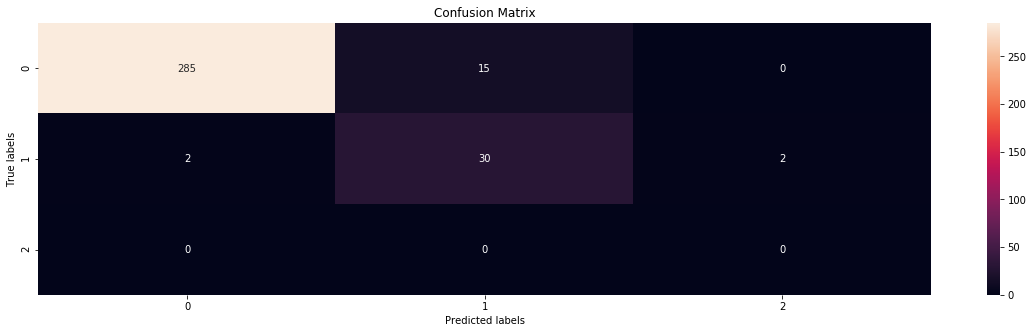

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       287
           1       0.88      0.67      0.76        45
           2       0.00      0.00      0.00         2

    accuracy                           0.94       334
   macro avg       0.61      0.55      0.58       334
weighted avg       0.94      0.94      0.94       334



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [108]:
RidgeRegressor = Ridge(alpha = 1145.4145)
ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)
predics = RidgeRegressor.predict(test_input_standardize)

predics_categorized = pd.cut(abs(predics), bins=bins, labels=bin_labels, include_lowest=True)
test_labels_categorized = pd.cut(abs(test_labels), bins=bins, labels=bin_labels, include_lowest=True)

cm = confusion_matrix(predics_categorized, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

#logistic_regression.score(X_test, y_test)
#plot_confusion_matrix(logistic_regression, X_test, y_test, display_labels = y_labels)
print(classification_report(test_labels_categorized, predics_categorized))